# Schelling Model (basic)


  __TODO__: Describe Schelling model and reference Think Complexity chapter.

### Imports

  In this model, we'll be importing a few extra libraries that we haven't seen before:
  
  * [copy](https://docs.python.org/2/library/copy.html)
  * [itertools](https://docs.python.org/2/library/itertools.html)

In [11]:
%matplotlib inline

# Imports
import copy
import itertools

import numpy
import matplotlib.pyplot as plt
import pandas

import seaborn; seaborn.set()

# Import widget methods
from IPython.html.widgets import *

## Building a grid

  In the sample below, we'll create a simple square grid and fill the grid with households.  The parameters below will guide our model as follows:
  
  * __``grid_size``__: the number of cells per row or column; the total number of cells is $grid\_size^2$.
  * __``group_proportion``__: the percentage of households that will be of type 1
  * __``density``__: the percentage of grid cells that will be populated with a household
  
  The logic for our grid initialization can be described as follows:
  
  * For each cell in every row and column
      * Draw a random value on $[0, 1)$ and compare to $density$ to determine if we will fill this cell
      * If the cell will be filled, draw a random value on $[0, 1)$ and compare to $group\_proportion$ to determine whether the household will be 1 or 2

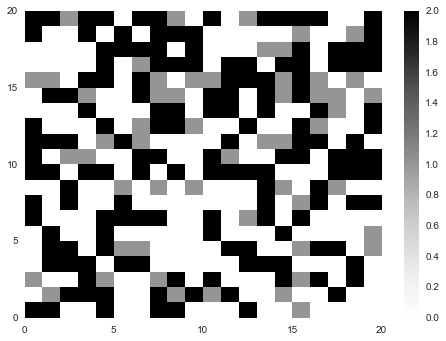

In [2]:
# Set parameters
grid_size = 20
group_proportion = 0.25
density = 0.5

# Create the space and activate random cells
space = numpy.zeros((grid_size, grid_size), dtype=numpy.int8)

# Now sample the agents.
for row_id in range(grid_size):
    for col_id in range(grid_size):
        # Determine if this cell will be populated
        if numpy.random.random() <= density:
            # Determine this cell's initial group
            if numpy.random.random() <= group_proportion:
                cell_type = 1
            else:
                cell_type = 2
            
            # Set the space
            space[row_id, col_id] = cell_type
        
# Now show the space
f = plt.figure()
p = plt.pcolor(space, snap=True)
c = plt.colorbar()

### Initialization method

  Below, we wrap the test method above in a method named ``initialize_space``.  We need to setup the following parameters:
  
  * __``grid_size``__: number of cells in each row or column
  * __``group_proportion``__: percentage of initial population that will be of group 1
  * __``density``__: percentage of cells that will be occupied in the space

In [3]:
def initialize_space(grid_size, group_proportion, density):
    """
    Initialize a space.
    """
    
    # Create the space and activate random cells
    space = numpy.zeros((grid_size, grid_size), dtype=numpy.int8)

    # Now sample the agents.
    for row_id in range(grid_size):
        for col_id in range(grid_size):
            # Determine if this cell will be populated
            if numpy.random.random() <= density:
                # Determine this cell's initial group
                if numpy.random.random() <= group_proportion:
                    cell_type = 1
                else:
                    cell_type = 2

                # Set the cell
                space[row_id, col_id] = cell_type

    return space

### Testing out space initialization

  Let's test out our ``initialize_space`` method by visualizing for given parameters below.

<function __main__.display_space>

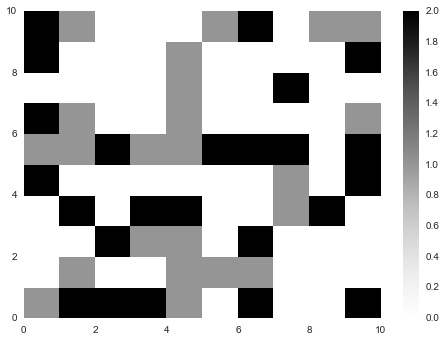

In [12]:
# Set parameters
grid_size = 10
group_proportion = 0.25
happy_proportion = 0.5
density = 0.5
window = 1

def display_space(grid_size=10, group_proportion=0.5, density=0.5):
    # Check
    assert(grid_size > 1)
    assert(group_proportion >= 0.0)
    assert(group_proportion <= 1.0)
    assert(density >= 0.0)
    assert(density <= 1.0)

    # Initialize space
    space = initialize_space(grid_size, group_proportion, density)

    # Plot
    f = plt.figure()
    p = plt.pcolor(space)
    c = plt.colorbar()

# Setup widget
interact(display_space,
         grid_size=IntSliderWidget(min=2, max=100, value=10),
         group_proportion=FloatSliderWidget(min=0.0, max=1.0, value=0.5),
         density=FloatSliderWidget(min=0.0, max=1.0, value=0.5))

In [18]:
# Pick a random household
household_list = numpy.column_stack(numpy.where(space > 0))
household_id = numpy.random.choice(range(len(household_list)))

# Check if the household is happy
row, col = household_list[household_id]
household_type = space[row, col]

# Get the set of positions with grid wrapping for neighbors
neighbor_pos = [(x % grid_size, y % grid_size)
                for x, y in itertools.product(range(row-window, row+window+1),
                                              range(col-window, col+window+1))]
neighborhood = numpy.reshape([space[x, y] for x, y in neighbor_pos],
              (2*window+1, 2*window+1))

# Count the number of neighbors of same type
neighbor_count = len(numpy.where(neighborhood == household_type)[0]) - 1
neighbor_fraction = float(neighbor_count) / ((2 * window + 1) **2 - 1)

print(neighbor_pos)
print(household_type)

print(neighborhood)

[(8, 3), (8, 4), (8, 5), (9, 3), (9, 4), (9, 5), (0, 3), (0, 4), (0, 5)]
1
[[0 0 0]
 [0 2 0]
 [0 1 0]]


In [19]:
# Output counts
print("Household type: {0}".format(household_type))
print("Neighborhood:")
print(neighborhood)
print("Number of similar neighbors:")
print(neighbor_count)
print("Fraction of similar neighbors:")
print(neighbor_fraction)

Household type: 1
Neighborhood:
[[0 0 0]
 [0 2 0]
 [0 1 0]]
Number of similar neighbors:
0
Fraction of similar neighbors:
0.0


In [383]:
def run_model_step(space, happy_proportion, window):
    """
    Run  a step of the model.
    """
    space = copy.copy(space)
    grid_size = space.shape[0]
    
    # Get list of empty and occupied
    household_list = numpy.column_stack(numpy.where(space > 0))
    
    # Pick a random house
    household_id = numpy.random.choice(range(len(household_list)))

    # Check if the household is happy
    row, col = household_list[household_id]
    household_type = space[row, col]
    
    # Get the set of positions with grid wrapping for neighbors
    neighbor_pos = [(x % grid_size, y % grid_size)
                    for x, y in itertools.product(range(row-window, row+window+1),
                                                  range(col-window, col+window+1))]
    neighborhood = numpy.reshape([space[x, y] for x, y in neighbor_pos],
                  (2*window+1, 2*window+1))

    # Count the number of neighbors of same type
    neighbor_count = len(numpy.where(neighborhood == household_type)[0]) - 1
    neighbor_fraction = float(neighbor_count) / ((2 * window + 1) **2 - 1)
    
    # If the house is unhappy, move.
    if neighbor_fraction < happy_proportion:
        # Get empty cells
        empty_list = numpy.column_stack(numpy.where(space == 0))
        
        # Get empty target cell
        target_cell_id = numpy.random.choice(range(len(empty_list)))
        target_row, target_col = empty_list[target_cell_id]
        
        # Move the agent
        space[row, col] = 0
        space[target_row, target_col] = household_type

    return space

In [20]:
# Set parameters
grid_size = 50
group_proportion = 0.33
happy_proportion = 0.33
density = 0.5
window = 1
max_steps = 100000

# Initialize space
space = initialize_space(grid_size, group_proportion, density)

# Setup space
space_history = [space]

# Iterate
for i in range(max_steps):
    # Append step history
    space_history.append(run_model_step(space_history[-1],
                                        happy_proportion,
                                        window))

In [23]:
def display_space_step(step):
    f = plt.figure()
    plt.pcolor(space_history[step])
    ax = f.gca()
    ax.set_aspect(1./ax.get_data_ratio())   

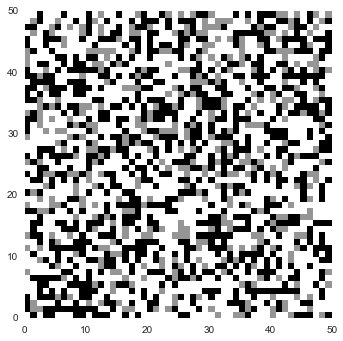

In [24]:
interact(display_space_step,
                step=IntSliderWidget(min=1, max=len(space_history)-1,
                                     step=1))

### Automate simulation

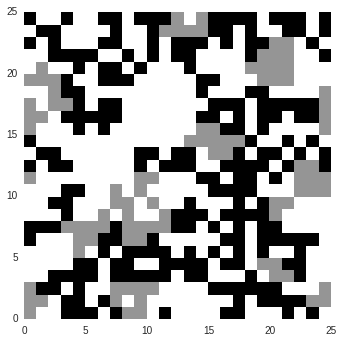

In [395]:
%%time

def run_model_simulation(grid_size = 50, group_proportion = 0.33, happy_proportion = 0.33,
                         density = 0.5, window = 1, max_steps = 100000):
    """
    Run a full model simulation.
    """

    # Initialize space
    space = initialize_space(grid_size, group_proportion, density)

    # Setup space
    space_history = [space]

    # Iterate
    for i in range(max_steps):
        # Append step history
        space_history.append(run_model_step(space_history[-1],
                                            happy_proportion,
                                            window))

    return space_history

# Run the simulation and output
space_history = run_model_simulation(grid_size=25, happy_proportion=0.25, window=1, max_steps=10000)
interact(display_space_step,
                step=IntSliderWidget(min=1, max=len(space_history)-1,
                                     step=1))

In [396]:
def get_neighbor_distribution(space, window=1):
    """
    Get distribution of neighbor fractions.
    """
    
    fractions = numpy.full(space.shape, numpy.nan)
    grid_size = space.shape[0]
    
    # Get a measure of clustering
    for row in range(grid_size):
        for col in range(grid_size):
            # Check if cell is occupied
            if space[row, col] == 0:
                continue
            else:
                household_type = space[row, col]
                
            neighbor_pos = [1 for x, y in itertools.product(range(row-window, row+window+1),
                                                          range(col-window, col+window+1))
                               if space[x % grid_size, y % grid_size] == household_type]
            fractions[row, col] = float(sum(neighbor_pos)-1) / ((2 * window + 1) **2 - 1)
    
    return fractions

# Get the full happiness history
happy_history = []
happy_mean_ts = []
for step in range(len(space_history)):
    happy_history.append(get_neighbor_distribution(space_history[step]))
    happy_mean_ts.append(numpy.nanmean(happy_history[-1]))

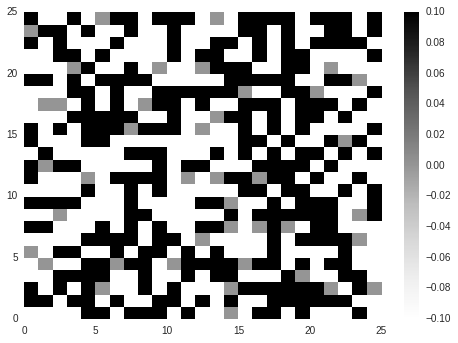

In [397]:
# Method to plot happiness surface
def display_happy_step(step=1):
    # Create figures
    f = plt.figure()
    plt.pcolor(happy_history[step])
    plt.colorbar()
    

# Create widget
interact(display_happy_step,
            step=IntSliderWidget(min=1, max=len(happy_history)-1,
                                 step=1))

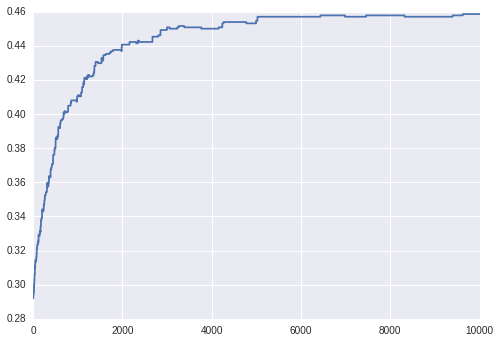

In [398]:
# Plot the average time series
f = plt.figure()
plt.plot(range(len(happy_mean_ts)), happy_mean_ts)